In [1]:
%matplotlib inline
import math
import os 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
import statsmodels.api as sm
from pandas import ExcelWriter
import pickle
import scipy as sp
import re

In [3]:
def load_object(filename):
    with open(filename, 'rb') as fid:
        file = pickle.load(fid)
    return file

def index(data, label):
    mini = data.reset_index()[data.reset_index()['labels'] == label].index.min()
    maxi = data.reset_index()[data.reset_index()['labels'] == label].index.max()
    return [mini,maxi]

def non_zero_data(data):
    #data = data.drop(columns = "ID")
    non_zero_rows = data.abs().sum(axis=1) > 0.0
    non_zero_data = data[non_zero_rows]
    #non_zero_columns = non_zero_data.abs().sum(axis=0) > 0.0
    #non_zero_data = non_zero_data.loc[: , non_zero_columns]
    return non_zero_data

#put multiple DFs together with the key
def combineddf(dflist, dfkeys, ELEMENTS, noise = None, coefficient = None,):
    #make an empty list
    combinedlist = []
    #make an empty dataframe
    combineddf12 = pd.DataFrame()

    for i,j in zip(dflist, dfkeys):
        if noise == None and coefficient == None:
            df = non_zero_data(i[ELEMENTS])
            #fillnan with 0
            df[np.isnan(df)] = 0
        else:
            #add noise
            df = addnoise(i[ELEMENTS], noise, coefficient)


        df['labels'] = j
        combinedlist.append(df)
        combineddf12 = pd.concat([combineddf12, df])
    return combineddf12

#Counts total number of peaks for each isotope
def marginal_particle(data):
    #replace 0 with nan
    data.replace(0, np.nan, inplace = True)
    return abs(data).count().sort_values(ascending=False)

ELEMENTS = ['46Ti', '48Ti', '53Cr', '55Mn', '54Fe', '57Fe', '59Co', '60Ni', '63Cu', '65Cu', '64Zn', '66Zn', '69Ga', '71Ga', '72Ge', '75As', '78Se', '85Rb', '88Sr', '89Y', '90Zr', '93Nb', 
           '98Mo', '108Pd', '107Ag', '109Ag', '114Cd', '118Sn', '120Sn', '121Sb', '133Cs', '138Ba', '139La', '140Ce', '152Sm', '153Eu', '158Gd', '159Tb', '164Dy', '165Ho',
           '166Er', '169Tm', '174Yb', '175Lu', '180Hf', '185Re', '192Os', '193Ir', '195Pt', '197Au', '202Hg', '206Pb', '208Pb', '238U', '51V']


In [5]:

#returns aggregate particles of a dataset
def aggregate_particles(data, element1 = None):
    total = []
    #go through each row
    for i in data.itertuples():
        labels = []
        #in that row, go through each element
        for j in range(1, len(i)):
            #if there is some value
            if i[j] > 0:
                #append the element into the labels list
                labels.append(data.columns[j - 1])
                #if there is no elements
                if labels[-1] == None:
                    print('ERROR')
        #if there are some elements in the labels list
        if labels != []:
            #append it to the total list
            total.append(labels)
    #make an array of this
    total = np.array(total)
    #only find the unique labels
    uniquelist = np.unique(total)
    
    
    #if element1 is there, focus on that one element
    if element1 != None:
        uniquelist = uniquelist[[element1 in i for i in uniquelist]]
        
    uniquelist1 = []
    #for each unique label
    for i in uniquelist:
        #join them together with a + sign
        uniquelist1.append('+'.join(i))
    totalvalue = []
    # for each unique label
    for i in uniquelist:
        value = 0
        # for each label in total
        for j in total:
            if i == j:
                #count how many there are
                value = value + 1
        totalvalue.append(value)

    finaldf = pd.DataFrame(totalvalue, uniquelist1, columns = ['Value']).sort_values('Value', ascending = False)
    return finaldf

    #returns aggregate particles of a dataset
def aggregate_particles_mod(data):
    total = []
    #go through each row
    for i in data.itertuples():
        labels = []
        #in that row, go through each element
        for j in range(1, len(i)):
            #if there is some value
            if i[j] > 0:
                #append the element into the labels list
                labels.append(data.columns[j - 1])
                #if there is no elements
                if labels[-1] == None:
                    print('ERROR')
        #if there are some elements in the labels list
        if labels != []:
            #append it to the total list
            total.append('+'.join(labels))
    #make an array of this
    total = np.array(total)
    #only find the unique labels
    uniquelist = np.unique(total)
    return total

#returns aggregate particles of a dataset
def aggregate_particles_specific(data, element1 = None):
    total = []
    #go through each row
    for i in data.itertuples():
        labels = []
        #in that row, go through each element
        for j in range(1, len(i)):
            #if there is some value
            if i[j] > 0:
                #append the element into the labels list
                labels.append(data.columns[j - 1])
                #if there is no elements
                if labels[-1] == None:
                    print('ERROR')
        #if there are some elements in the labels list
        if labels != []:
            #append it to the total list
            total.append(labels)
    #make an array of this
    total = np.array(total)
    #only find the unique labels
    uniquelist = np.unique(total)
    
    
    #if element1 is there, focus on that one element
    if element1 != None:
        uniquelist = uniquelist[[element1 in i for i in uniquelist]]
        
    uniquelist1 = []
    #for each unique label
    for i in uniquelist:
        #join them together with a + sign
        uniquelist1.append('+'.join(i))
    totalvalue = []
    # for each unique label
    for i in uniquelist:
        value = 0
        # for each label in total
        for j in total:
            if i == j:
                #count how many there are
                value = value + 1
        totalvalue.append(value)

    finaldf = pd.DataFrame(totalvalue, uniquelist1, columns = ['Value']).sort_values('Value', ascending = False).reset_index()
    return finaldf, total

#Type: Data Frame. From a selected isotope and its particle events, select all other isotopes associated and drop others not associated with it
def isotope_particle(data, isotope):
    obs = data[data[isotope]>0.0]
    return obs

In [6]:
#load the codes
Sourcetrainingcodes = load_object('models/Revision_isotopes/Sourcesamples_trainingcodes_iso.pkl')
Sourcetestingcodes = load_object('models/Revision_isotopes/Sourcesamples_testingcodes_iso.pkl')

Sourcetraining, Sourcekeys = load_object('models/Revision_isotopes/SourcetrainingDF_iso.pkl')
Sourcetesting, Sourcekeys = load_object('models/Revision_isotopes/SourcetestingDF_iso.pkl')

#load mapping feature
m = load_object('models/Revision_isotopes/randommappingfeature_iso.pkl')

# choose the best model and apply on samples

In [7]:
#try alpha = 0.01 and number of clusters = 10

#fit the Sourcecodes_training
from sklearn.decomposition import LatentDirichletAllocation

model2 = LatentDirichletAllocation(n_components=10, doc_topic_prior = 0.01)

#Sourcetesting = Sourcetesting.loc[non_zero_data(Sourcetesting[ELEMENTS]).index]
#Sourcetesting.reset_index(drop = True, inplace = True)

#Sourcetraining = Sourcetraining.loc[non_zero_data(Sourcetraining[ELEMENTS]).index]
#Sourcetraining.reset_index(drop = True, inplace = True)

In [8]:
model2 = model2.fit(Sourcetrainingcodes)

Qian2016prob = model2.transform(Qian2016codes)
maxprob = Qian2016prob.max(axis = 1)
clustermax = Qian2016prob.argmax(axis = 1)

Sourceprob = model2.transform(Sourcetrainingcodes)
Sourcemaxprob = Sourceprob.max(axis = 1)
Sourceclustermax = Sourceprob.argmax(axis = 1)

Sourcetestingprob = model2.transform(Sourcetestingcodes)
Sourcetestingmaxprob = Sourcetestingprob.max(axis = 1)
Sourcetestingclustermax = Sourcetestingprob.argmax(axis = 1)

In [9]:
#save object
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [10]:
save_object(model2, 'models/Revision_isotopes/LDAModel_iso.pkl')

# combine dataframe

In [11]:
#Sourcetesting = combineddf(Sourcetesting, Sourcekeys, ELEMENTS)

Sourcetesting['elements'] = aggregate_particles_mod(Sourcetesting[ELEMENTS])
Sourcetesting['cluster'] = Sourcetestingprob.argmax(axis = 1)
Sourcetesting['max prob'] = Sourcetestingprob.max(axis = 1)

In [12]:
#Sourcetraining = combineddf(Sourcetraining, Sourcekeys, ELEMENTS)

Sourcetraining['elements'] = aggregate_particles_mod(Sourcetraining[ELEMENTS])
Sourcetraining['cluster'] = Sourceprob.argmax(axis = 1)
Sourcetraining['max prob'] = Sourceprob.max(axis = 1)

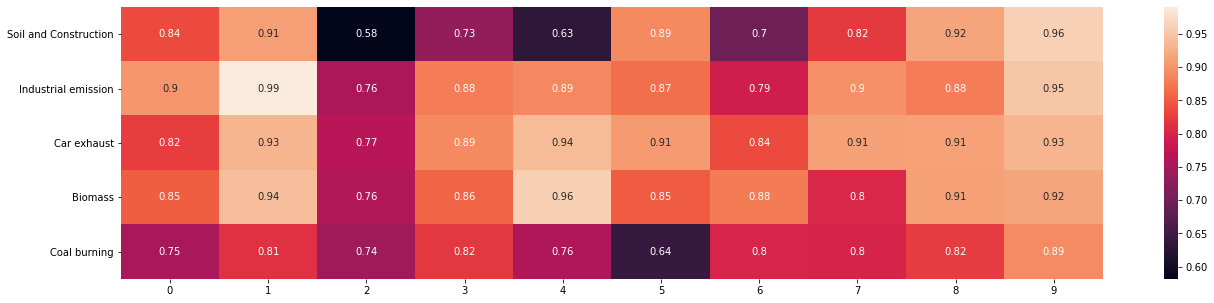

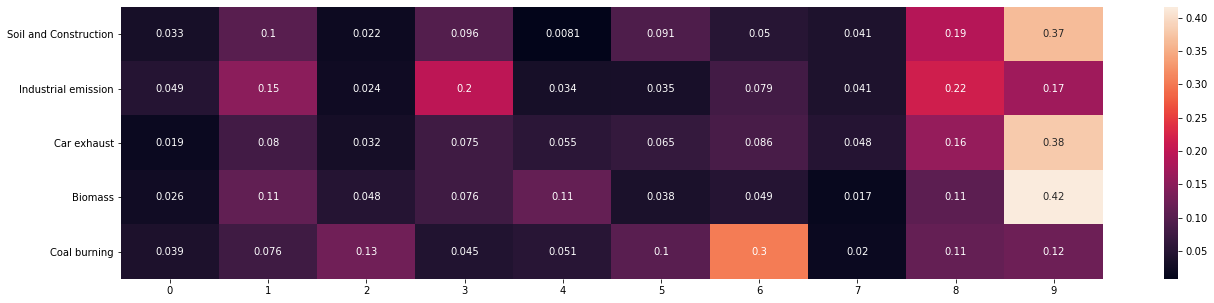

In [13]:
Sourceprob = model2.transform(Sourcetrainingcodes)
    
soilconconf = np.zeros(Sourceprob[index(Sourcetraining, 'Soil and Construction')[0]: index(Sourcetraining, 'Soil and Construction')[1]].shape)
indemissionconf = np.zeros(Sourceprob[index(Sourcetraining, 'Industrial emission')[0]: index(Sourcetraining, 'Industrial emission')[1]].shape)
carexhaustconf = np.zeros(Sourceprob[index(Sourcetraining, 'Car exhaust')[0]: index(Sourcetraining, 'Car exhaust')[1]].shape)
biomassconf = np.zeros(Sourceprob[index(Sourcetraining, 'Biomass')[0]: index(Sourcetraining, 'Biomass')[1]].shape)
coalburningconf = np.zeros(Sourceprob[index(Sourcetraining, 'Coal burning')[0]: index(Sourcetraining, 'Coal burning')[1]].shape)

indexconf = ['Soil and Construction', 'Industrial emission', 'Car exhaust', 'Biomass', 'Coal burning']
conflist = [soilconconf, indemissionconf, carexhaustconf, biomassconf, coalburningconf]

for indexm, matrix in zip(indexconf, conflist):
    #print(indexm)
    intermediateargmax = Sourceprob[index(Sourcetraining, indexm)[0]: index(Sourcetraining, indexm)[1]].argmax(axis=1)
    intermediatemax = Sourceprob[index(Sourcetraining, indexm)[0]: index(Sourcetraining, indexm)[1]].max(axis=1)
    for i in np.arange(0, len(matrix)):
        matrix[i, intermediateargmax[i]] = intermediatemax[i]

    #find the average and the count for every component
confcountcomb = np.zeros([5, 10])
confavgcomb = np.zeros([5, 10])
for ind, conf in enumerate(conflist):
    confcount = np.zeros([1,10])
    for inds in np.arange(0, 10):
        confcount[:,inds] = len(conf[:,inds][np.nonzero(conf[:,inds])])/len(conf)

    confaverage = np.zeros([1,10])
    for inds in np.arange(0, 10):
        confaverage[:,inds] = np.average(conf[:,inds][np.nonzero(conf[:,inds])])
    confcountcomb[ind] = confcount
    confavgcomb[ind] = confaverage

fig = plt.figure(figsize = (22,5))
sns.heatmap(pd.DataFrame(confavgcomb, index = indexconf), annot = True)
plt.savefig('Figures/heatmapprobscluster.png', dpi = 300)

fig = plt.figure(figsize = (22,5))
sns.heatmap(pd.DataFrame(confcountcomb, index = indexconf), annot = True)
plt.savefig('Figures/heatmapcountscluster.png', dpi = 300)

# Get the unique matrix for the cluster for each source

In [14]:
from sklearn.neighbors import KNeighborsClassifier
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

def sourceclustermax(sampledf, ELEMENTS, sourcedf):

    totaldf = pd.DataFrame()
    y_scoredf = pd.DataFrame()
    Binarytestlabelsdf = pd.DataFrame()

    for cluster in np.arange(0,10):
        #all particles that is the first sample and the first cluster
        train = sourcedf[sourcedf['cluster'] == cluster]
        test = sampledf[sampledf['cluster'] == cluster]

        totaldf1 = pd.DataFrame()
        y_scoredf1 = pd.DataFrame()
        Binarytestlabelsdf1 = pd.DataFrame()

        #get the elements column in dataframe
        for particle in test['elements'].unique():
            trainingdf = train[train['elements'] == particle]
            testingdf = test[test['elements'] == particle]
            model = KNeighborsClassifier(n_neighbors = int(math.ceil(0.2*len(trainingdf))), weights = 'distance')
            Binarymodel = OneVsRestClassifier(model)
            try:
                model.fit(trainingdf[ELEMENTS], trainingdf['labels'])
                testingdf.loc[:,'Probable Source'] = model.predict(testingdf[ELEMENTS])

                BinaryTrainlabels = label_binarize(trainingdf['labels'], classes = Sourcekeys)
                BinaryTestlabels = label_binarize(testingdf['labels'], classes = Sourcekeys)
                Binarymodel.fit(trainingdf[ELEMENTS], BinaryTrainlabels)
                y_score = Binarymodel.predict_proba(testingdf[ELEMENTS])
            except:
                testingdf.loc[:,'Probable Source'] = 'Uncertain'

            totaldf1 = pd.concat([totaldf1, testingdf])
            Binarytestlabelsdf1 = pd.concat([Binarytestlabelsdf1, pd.DataFrame(BinaryTestlabels)])
            y_scoredf1 = pd.concat([y_scoredf1, pd.DataFrame(y_score)])

        totaldf = pd.concat([totaldf,  totaldf1])
        Binarytestlabelsdf = pd.concat([Binarytestlabelsdf, Binarytestlabelsdf1])
        y_scoredf = pd.concat([y_scoredf, y_scoredf1])

    return totaldf, y_scoredf, Binarytestlabelsdf

In [15]:
Sourcetestingtotaldf, yscoredftest, Btest1 = sourceclustermax(Sourcetesting, ELEMENTS, Sourcetraining)
Sourcetrainingtotaldf, scoredftrain, Btrain1 = sourceclustermax(Sourcetraining, ELEMENTS, Sourcetraining)

C:\Users\garre\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\garre\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\garre\anaconda3\lib\site-packages\sklearn\multiclass.py:80: UserWarning: Label 0 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
C:\Users\g

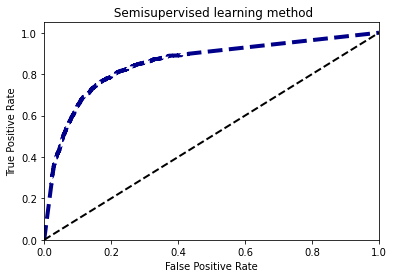

In [16]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(Sourcekeys)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Btest1.loc[:, i], yscoredftest.loc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(Btest1).ravel(), np.array(yscoredftest).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
df =  pd.DataFrame(index = roc_auc.keys(), data = roc_auc.values())

# Plot all ROC curves
plt.plot(fpr["micro"], tpr["micro"], label = 'micro average', linestyle='--', linewidth=4, color = 'darkblue')

#plt.plot(fpr["macro"], tpr["macro"], label = 'macro average', linestyle=':', linewidth=4, color = 'blue')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title(' Semisupervised learning method')
#plt.legend(loc="lower right")
plt.savefig('Figures/ROCcurvesemisupervised.png', dpi = 300)

In [17]:
#testing error
len(Sourcetestingtotaldf[Sourcetestingtotaldf['labels'] == Sourcetestingtotaldf['Probable Source']])/len(Sourcetestingtotaldf)

0.5728194726166329

In [16]:
#testing error
len(Sourcetrainingtotaldf[Sourcetrainingtotaldf['labels'] == Sourcetrainingtotaldf['Probable Source']])/len(Sourcetrainingtotaldf)

1.0